# Titanic


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

import sys
sys.path.append("../scripts")
from modules import function

In [80]:
train_data = pd.read_csv("../data/raw/train.csv")
test_data = pd.read_csv("../data/raw/test.csv")

In [10]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/Users/junya/.pyenv/versions/3.9.11/lib/python3.9/site-packages/matplotlib/colors.py:1311: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/Users/junya/.pyenv/versions/3.9.11/lib/python3.9/site-packages/matplotlib/ticker.py:521: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)


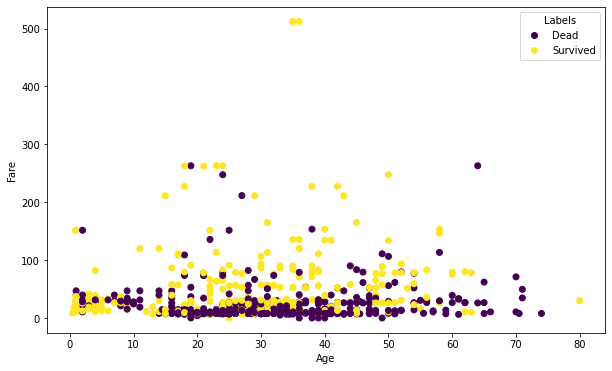

In [11]:
x_label = "Age"
y_label = "Fare"
fig, ax = plt.subplots(figsize=(10,6))
scatter = ax.scatter(train_data[x_label], train_data[y_label], c=train_data["Survived"], cmap='viridis')

# 軸ラベルの設定
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

# 凡例の表示
legend_labels = ['Dead', 'Survived']
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Labels')


In [12]:
train_data.columns
print("Possible values for the sex column: ", (set(train_data["Sex"])))

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
# Inspect any numeric column
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [42]:
def add_one_hot_sex(df):
    """ Add one hot vector of sex 

    Args:
        df (pd dataframe):

    Returns:
        _type_: df
    """
    if ("Sex" in df.columns):
        one_hot_sex = pd.get_dummies(df['Sex'], prefix = 'Sex')
        df = pd.concat([df, one_hot_sex], axis = 1)
        df.pop("Sex")
        df.pop("Sex_male")
        
    return df

In [15]:
print("Possible values for the sex column: ", (set(train_data["Embarked"])))

Possible values for the sex column:  {nan, 'Q', 'S', 'C'}


In [71]:
use_columns = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex"]
y_train = train_data["Survived"]
train_data = train_data[use_columns]
test_data = test_data[use_columns]






In [72]:
train_data = add_one_hot_sex(train_data)
test_data = add_one_hot_sex(test_data)


In [73]:
df = train_data
df = test_data

def nan_to_mean(df):
    df = df.fillna(df.mean())
    return df
train_data = nan_to_mean(train_data)
test_data = nan_to_mean(test_data)

In [74]:
x_train = train_data
x_test = test_data

In [76]:
lgbm_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'accuracy',
            'num_leaves': 10,
            "max_depth": 5,
            'learning_rate': 0.01,

            'n_estimators': 100,
            'random_state': 42,
            "class_weight": "balanced"
        }

clf = lgb.LGBMClassifier(**lgbm_params)
clf.fit(x_train, y_train)


LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=5,
               metric='accuracy', num_leaves=10, objective='binary',
               random_state=42)

In [78]:
prediction=clf.predict(x_test)

In [82]:
PassengerId = np.array(test_data["PassengerId"]).astype(int)
 
# my_prediction(予測データ）とPassengerIdをデータフレームへ落とし込む
my_solution = pd.DataFrame(prediction, PassengerId, columns = ["Survived"])
 
# my_tree_one.csvとして書き出し
my_solution.to_csv("../data/processed/prediction.csv", index_label = ["PassengerId"])
 